In [1]:
import numpy as np
import pandas as pd 
import hvplot as hv
import hvplot.pandas
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from src.util.model import eval_model, prep_data
seed = 42

In [2]:
dff0 = pd.DataFrame()

data_fp = "../../data/training_data"
for fn in os.listdir(data_fp):
    df = pd.read_csv(os.path.join(data_fp, fn))
    print(f"{fn} {df.shape}")
    if fn.split(".")[0][-1] == "1":
        continue
    else:
        dff0 = pd.concat([dff0, df])
print(dff0.shape)

snow_2020-2025_p160_fxx1.csv (35016, 68)
snow_2020-2025_p160_fxx0.csv (29184, 68)
snow_2020-2025_p159_fxx0.csv (29184, 68)
snow_2020-2025_p159_fxx1.csv (35016, 68)
(58368, 68)


In [3]:
danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])
danger_levels = danger_levels[danger_levels['forecast_zone_id'] == "whitefish"]
danger_levels = danger_levels[danger_levels['lower'] > -1]
danger_levels = danger_levels[['date','lower']]
danger_levels = danger_levels.drop_duplicates()
print(danger_levels.shape)
print(danger_levels.head())

(802, 2)
         date  lower
20 2020-10-19      0
21 2020-10-20      0
22 2020-10-21      0
23 2020-10-22      0
24 2020-10-23      0


In [4]:
X, y = prep_data(
    dff0, 
    danger_levels, 
    "lower", 
    replace_missing=True, 
    change_danger=True, 
    exclude_cols=['date','id','slope_azi', 'danger_level','altitude']) 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [61]:
rf = RandomForestClassifier(random_state=seed, 
                            n_estimators=100, 
                            max_depth=10, 
                            class_weight="balanced",
                            min_samples_split=10,
                            min_samples_leaf=2)

rf.fit(X_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Train
Accuracy 0.88
MSE: 0.13368983957219252
RMSE: 0.36563621206356534
MAE: 0.12299465240641712
Test
Accuracy 0.61
MSE: 0.6307053941908713
RMSE: 0.7941696255781074
MAE: 0.46473029045643155


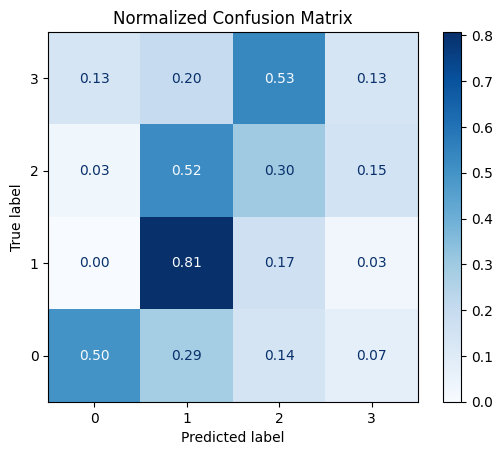

In [62]:
y_pred = rf.predict(X_test)

print("Train")
eval_model(y_train, rf.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)

In [63]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=False)
print(feature_importances[feature_importances['importance'] > 0])

                      importance
HN72_24                 0.034860
mAlbedo                 0.032222
ISWR_diff               0.031825
ski_pen                 0.029773
HS_meas                 0.029505
hoar_size               0.028418
TA                      0.027918
Qs                      0.026779
pAlbedo                 0.025897
Sclass2                 0.025109
T_bottom                0.024726
SWE                     0.024474
MS_Water                0.024196
TSS_mod                 0.024125
RH                      0.023701
Ql                      0.023443
OLWR                    0.023399
HS_mod                  0.023377
ColdContentSnow         0.022457
S5                      0.022352
OSWR                    0.021855
zS4                     0.021841
Sd                      0.021501
ILWR                    0.020302
ISWR                    0.020261
TSG                     0.019912
ISWR_h                  0.019861
zSn                     0.019285
zSd                     0.018686
LWR_net   